In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
torch.manual_seed(42)
os.environ['PJRT_DEVICE'] = 'TPU' 
# os.environ['PT_XLA_DEBUG_LEVEL'] = '2'
# os.environ['XLA_DYNAMO_DEBU'] = '1'
# os.environ['PT_XLA_DEBUG'] = '1'
# os.environ['XLA_SYNC_WAIT'] = '1'
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn
import timm
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

W0817 08:41:57.985000 140702217401920 torch/_inductor/compile_worker/subproc_pool.py:126] SubprocPool unclean exit


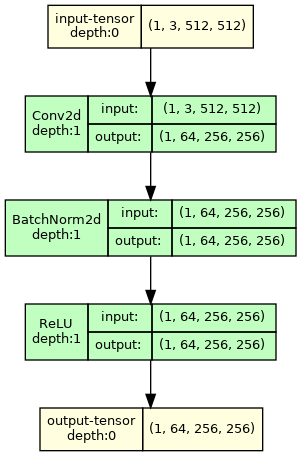

In [2]:
import torchvision
from torchview import draw_graph
import graphviz

resnet = torchvision.models.resnet.resnet50(pretrained=True)
input_block = nn.Sequential(*list(resnet.children()))[:3]

graphviz.set_jupyter_format('png')
model_graph = draw_graph(input_block, input_size=(1,3,512,512))
model_graph.visual_graph

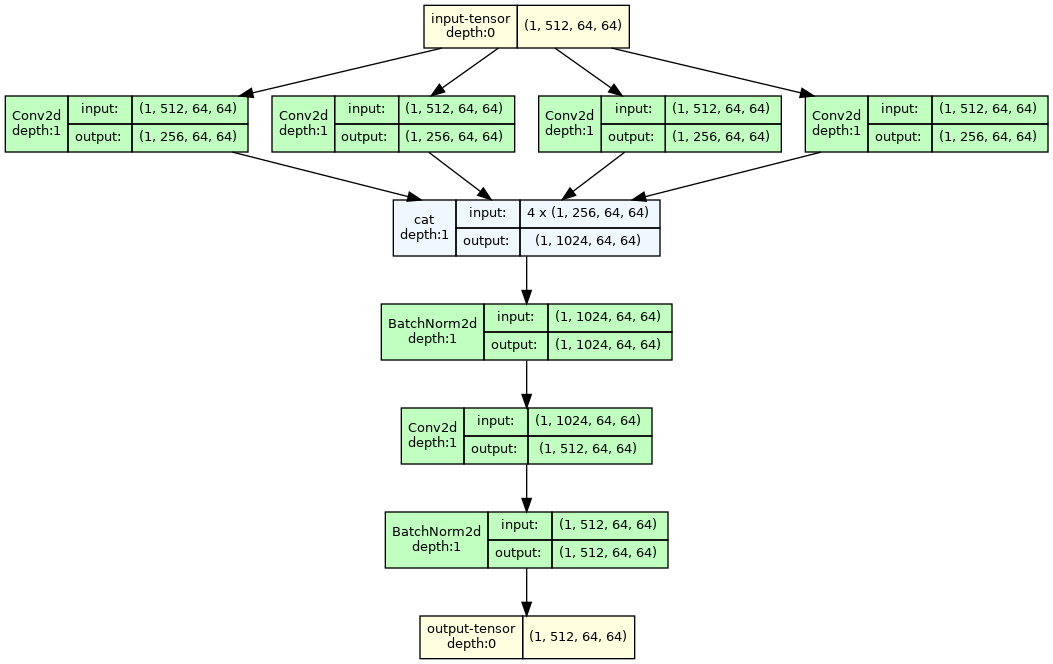

In [3]:
class Atrous_Convolution(nn.Module):
    def __init__(self, img_size = 64, in_channels=32, out_channels=64, dilation_rate=0, kernel_size = 3, padding = 'same'):
        super().__init__()
        self.img_size = img_size
        self.dilation_rate = dilation_rate
        self.kernel_size = kernel_size
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.ModuleList([nn.Conv2d(in_channels = self.in_channels, 
                                   out_channels = self.out_channels//2, 
                                   kernel_size = self.kernel_size[i], 
                                   padding = self.padding,
                                   dilation = self.dilation_rate[i]) for i in range(len(dilation_rate))]
                                 )
        self.batchnorm = nn.BatchNorm2d(self.in_channels*2)
        self.batchnorm_1 = nn.BatchNorm2d(self.out_channels)
        self.one_cross_one_conv = nn.Conv2d(in_channels = self.out_channels*2, out_channels = self.out_channels, kernel_size = 1, dilation = 1, padding = 'same')
    def forward(self, x):
        op = []
        for block in self.conv:
            op.append(block(x))
        op = torch.cat(op, axis = 1)
        op = self.batchnorm(op)
        op = self.one_cross_one_conv(op)
        op = self.batchnorm_1(op)
        return op
atr_conv = Atrous_Convolution(img_size = 32, in_channels = 512, out_channels = 512, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3])
model_graph = draw_graph(atr_conv, input_size=(1,512,64, 64), expand_nested=True)
model_graph.visual_graph


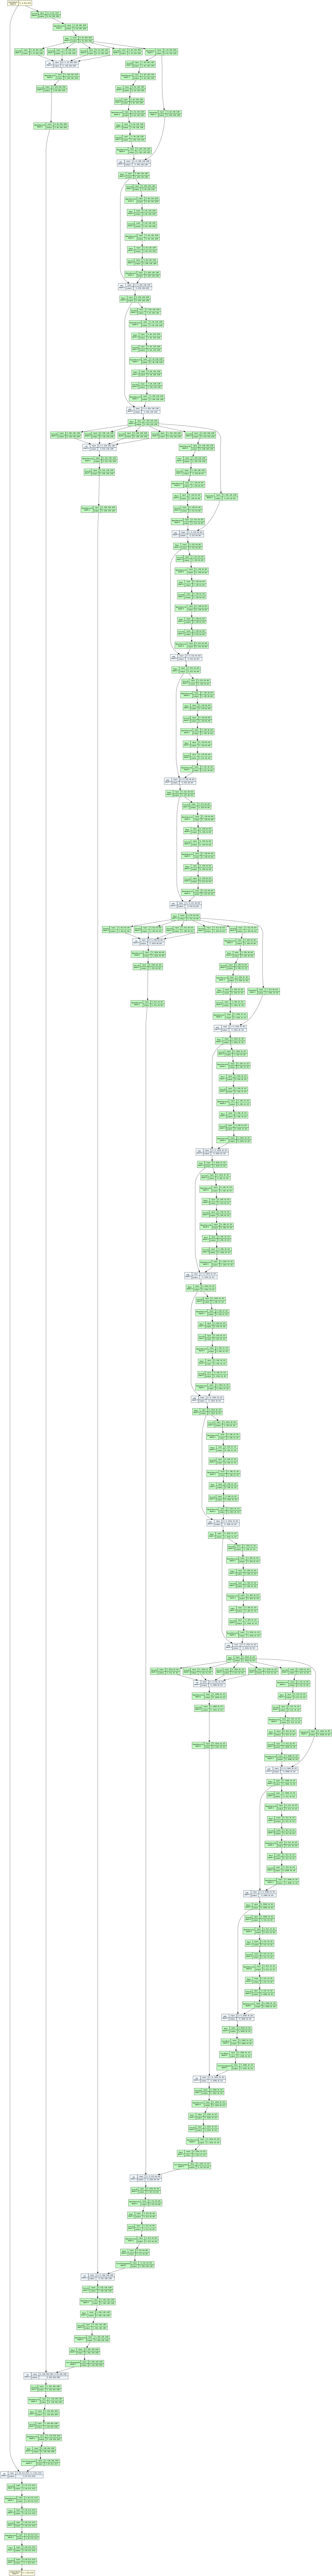

In [4]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        atrous_convolutions = []
        atrous_convolutions.append(Atrous_Convolution(in_channels = 1024, out_channels = 1024, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        atrous_convolutions.append(Atrous_Convolution(in_channels = 512, out_channels = 512, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        atrous_convolutions.append(Atrous_Convolution(in_channels = 256, out_channels = 256, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        # atrous_convolutions.append(Atrous_Convolution(in_channels = 128, out_channels = 128, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        atrous_convolutions.append(Atrous_Convolution(in_channels = 64, out_channels = 64, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))

        self.atrous_convolutions = nn.ModuleList(atrous_convolutions)
        
        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)
        attr = []
        
        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            # print(i)
            if i < 5:
                x = block(x, self.atrous_convolutions[i-1](pre_pools[key]))
            else:
                x = block(x, pre_pools[key])
            
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

model = UNetWithResnet50Encoder()
inp = torch.rand((2, 3, 512, 512))
import torchvision
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size=(1,3,512,512))
model_graph.visual_graph

In [5]:
class_names = ['background', 'building']
select_classes = ['background', 'building']
class_rgb_values = [[0], [1]]
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0], [1]]


In [13]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import skimage.io as io
import os
import albumentations
import albumentations.pytorch

class Custom_Dataset(Dataset):
    def __init__(self, img_dir, annotation_file, class_rgb_values = None, transforms = None, preprocessing = None):
        self.img_dir = img_dir
        self.annotation_file = annotation_file
        self.coco = COCO(annotation_file)
        self.img_ids = self.coco.getImgIds()
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.class_rgb_values = class_rgb_values
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = (np.array(io.imread(img_path)))
        
        annotation_ids = self.coco.getAnnIds(imgIds = img_info['id'])
        annotations = self.coco.loadAnns(annotation_ids)

        mask = np.zeros((img_info['height'], img_info['width']))
        
        for annotation in annotations:
            # Get the segmentation polygons
            segmentation = annotation['segmentation']
            
            # If the segmentation is a list of polygons
            if isinstance(segmentation, list):
                rles = maskUtils.frPyObjects(segmentation, img_info['height'], img_info['width'])
                rle = maskUtils.merge(rles)
                mask += maskUtils.decode(rle)
            # If the segmentation is a RLE
            else:
                mask = maskUtils.merge([mask, maskUtils.decode(maskUtils.frPyObjects(segmentation, img_info['height'], img_info['width']))])
        
        if self.transforms:
            transformed = self.transforms(image = image, mask = mask)
            image = transformed['image']
            mask = transformed['mask']
            
        mask[mask > 1] = 0
        mask = (mask).unsqueeze(0)
        sample = {'img' : image, "mask" : mask}
        
        return sample

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the albumentations transformation
transform = A.Compose([
    A.CropNonEmptyMaskIfExists(
        height=256,  # int
        width=256,  # int
        ignore_values=[0],  # list[int] | None
        ignore_channels=None,  # list[int] | None
        always_apply=False,  # bool | None
        p=1.0,  # float
    ),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p = 0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512, p=1),
    ToTensorV2()
])

In [14]:
# dataset = Custom_Dataset('/home/shashank/IEEE/train//', '/home/shashank/IEEE/train/train.json')
dataset = Custom_Dataset('/home/shashank/IEEE/train/', '/home/shashank/IEEE/train/train.json', transforms = transform, class_rgb_values=select_class_rgb_values)
v_dataset = Custom_Dataset('/home/shashank/IEEE/val/', '/home/shashank/IEEE/val/val.json', transforms = val_transform, class_rgb_values=select_class_rgb_values)

sample = dataset.__getitem__(0)
print(sample['img'].shape)
print(sample['mask'].shape)


loading annotations into memory...
Done (t=1.57s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [15]:
print(sample['mask'].shape)

torch.Size([1, 256, 256])


(4, 1, 256, 256)


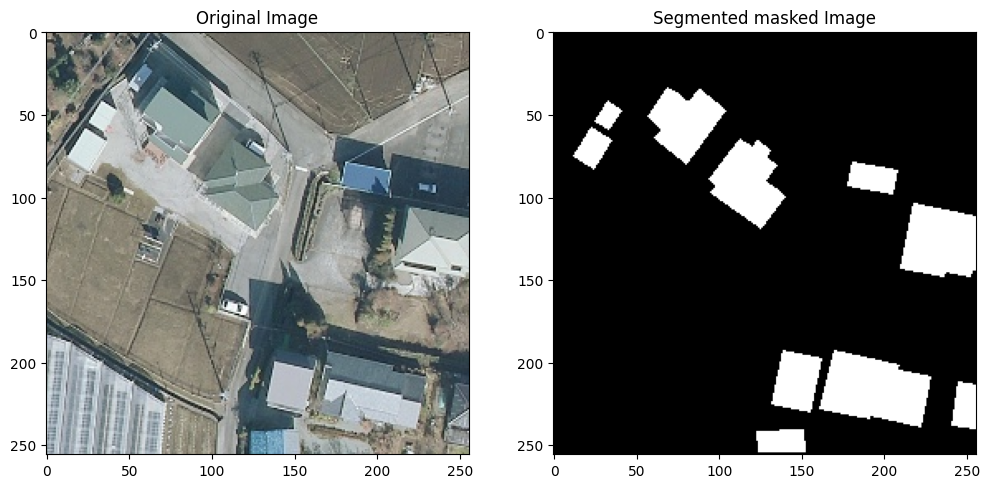

In [29]:
datal = torch.utils.data.DataLoader(dataset, batch_size = 4)
for step, batch in enumerate(datal):
    break

print(batch['mask'].squeeze(0).detach().cpu().numpy().shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(batch['img'][1].permute(1,2,0))
ax[0].set_title('Original Image')

ax[1].imshow((batch['mask'][1].squeeze(0).detach().cpu().numpy()), alpha=1.0, cmap='grey')
ax[1].set_title('Segmented masked Image')

plt.show()

In [30]:
batch['mask'].unique()

tensor([0., 1.], dtype=torch.float64)

In [26]:
import segmentation_models_pytorch as smp

def custom_loss(pred, target):
    pred = torch.sigmoid(pred)
    criterion = smp.losses.DiceLoss(mode = 'binary')
    loss = criterion(pred, target)

    tp, fp, fn, tn = smp.metrics.get_stats(pred, target.int(), mode='binary', threshold=0.5)
    
    # then compute metrics with required reduction (see metric docs)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
    return loss, iou_score

inp = torch.randn((4, 1, 256, 256))

print(custom_loss(inp, batch['mask']))

(tensor(0.7190), tensor(0.1554))


In [28]:
inp = torch.rand((2, 3, 512, 512))
op = model(inp)
op.shape

torch.Size([2, 1, 512, 512])

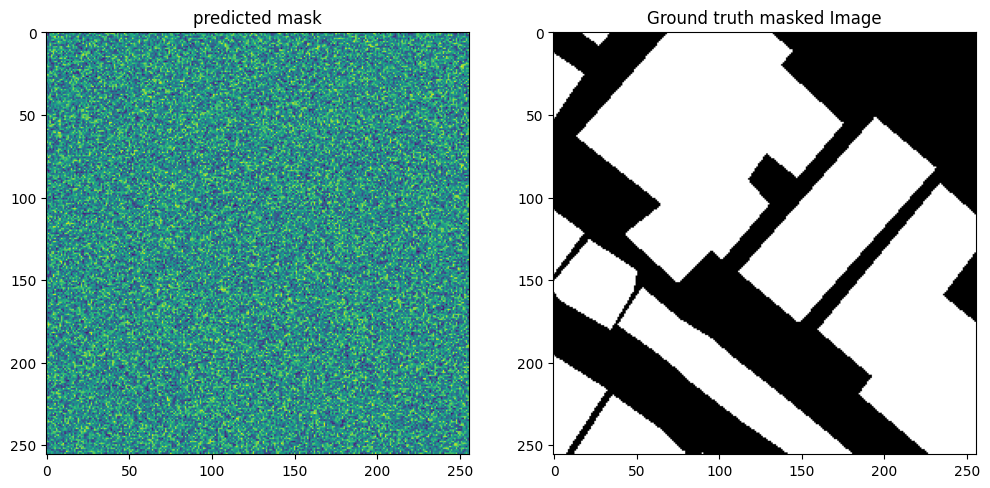

In [32]:
def plot(pred, mask):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    pred = torch.sigmoid(pred)
    # pred[pred > 0.5] = 1
    # pred[pred < 0.5] = 0
    ax[0].imshow(pred[0].squeeze(0).detach().cpu().numpy())
    ax[0].set_title('predicted mask')
    
    ax[1].imshow((mask[0].squeeze(0).detach().cpu().numpy()), alpha=1.0, cmap='grey')
    ax[1].set_title('Ground truth masked Image')
    
    plt.show()
inp = torch.randn((4, 1, 256, 256))
plot(inp, batch['mask'])

In [33]:
def reduce_fn(vals):
    # take average
    return sum(vals) / len(vals)
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
    train_loss = []
    train_iou = []
    valid_loss = []
    valid_iou = []

    model.train()
    scheduler.step()
    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        mask = batch['mask'].to(device)
                               
        optimizer.zero_grad()

        outputs = model(image)
        loss, iou_score = criterion(outputs, mask)
        loss.sum().backward()
        
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
        iou_score_reduced = xm.mesh_reduce('iou_reduce',iou_score,reduce_fn)
        
        if step%100 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}  iou_score: {iou_score_reduced}')

        train_loss.append(loss_reduced.detach().cpu().numpy())
        train_iou.append(iou_score_reduced.detach().cpu().numpy())
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            mask = batch['mask'].to(device)
            outputs = model(image)

            loss, iou_score = criterion(outputs, mask)
            loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
            iou_score_reduced = xm.mesh_reduce('iou_reduce',iou_score,reduce_fn)
            
            if step%100 == 0:
                xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}  iou_score: {iou_score_reduced}')
                gc.collect

            valid_loss.append(loss_reduced.detach().cpu().numpy())
            valid_iou.append(iou_score_reduced.detach().cpu().numpy())
            
    if epoch % 2 == 0:
        plot(mask, outputs)
        
    return np.mean(train_loss), np.mean(valid_loss), np.mean(train_iou), np.mean(valid_iou)

In [34]:
def data():

    train_transform = A.Compose([
        A.CropNonEmptyMaskIfExists(
            height=256,  # int
            width=256,  # int
            ignore_values=[0],  # list[int] | None
            ignore_channels=None,  # list[int] | None
            always_apply=False,  # bool | None
            p=1.0,  # float
        ),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p = 0.5),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(512, 512),
        ToTensorV2()
    ])
    
    ##Train Dataset
    train_dataset = Custom_Dataset('/home/shashank/IEEE/train/', '/home/shashank/IEEE/train/train.json', transforms = transform, class_rgb_values=select_class_rgb_values)

    ##Test Dataset
    test_dataset = Custom_Dataset('/home/shashank/IEEE/val/', '/home/shashank/IEEE/val/val.json', transforms = val_transform, class_rgb_values=select_class_rgb_values)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=16,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=16,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test, train_dataset.__len__()

In [ ]:
from tqdm import tqdm
def train_function(model, length, epochs):
    criterion = custom_loss
    lr = 0.00001
    num_train_steps = int(
        length / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    train_dataloader, test_dataloader, length = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = xm.xla_device()
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in (range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss, train_iou, valid_iou = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, criterion, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}, Train IOU: {train_iou}, Valid IOU: {valid_iou}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f},  Train IOU: {train_iou}, Valid IOU: {valid_iou}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./unet_model.pth')


def _mp_fn(rank, flags):
    try:
        model = UNetWithResnet50Encoder()
        dev = xm.xla_device()
        model = model.to(dev)
        dataloader_train, dataloader_test, length = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, length, epochs=30)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=4, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

In [ ]:
# """ Parts of the U-Net model """

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


# class Up(nn.Module):
#     """Upscaling then double conv"""

#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super().__init__()

#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         # if you have padding issues, see
#         # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
#         # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)


# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)
# # from .unet_parts import *


# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=False):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = (DoubleConv(n_channels, 64))
#         self.down1 = (Down(64, 128))
#         self.down2 = (Down(128, 256))
#         self.down3 = (Down(256, 512))
#         factor = 2 if bilinear else 1
#         self.down4 = (Down(512, 1024 // factor))
#         self.up1 = (Up(1024, 512 // factor, bilinear))
#         self.up2 = (Up(512, 256 // factor, bilinear))
#         self.up3 = (Up(256, 128 // factor, bilinear))
#         self.up4 = (Up(128, 64, bilinear))
#         self.outc = (OutConv(64, n_classes))

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits
# model = UNet(3, 1)
# # model = Unet()
# import torchvision
# from torchview import draw_graph
# import graphviz
# graphviz.set_jupyter_format('png')

# model_graph = draw_graph(model, input_size=(1,3,512,512))
# model_graph.visual_graph